In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from math import comb

plt_style = {"text.usetex": True,
             "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
             "axes.spines.right" : False,
             "axes.spines.top" : False,
             "font.size": 22,
             "savefig.dpi": 600,
             "savefig.bbox": 'tight'
            }

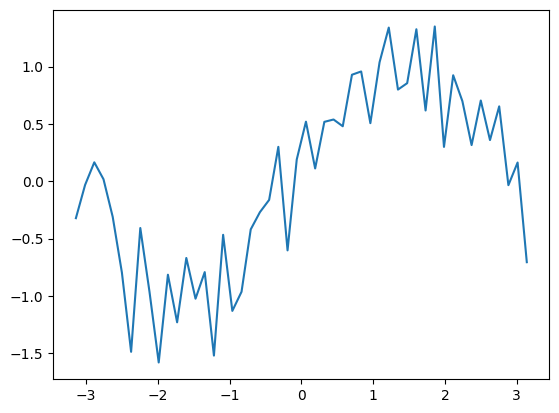

In [2]:
# Noisy training data
noise = 0.4
x = np.linspace(-np.pi, np.pi).reshape(-1, 1)
y0 = np.sin(x) + noise * np.random.randn(*x.shape)
fig, ax = plt.subplots()
ax.plot(x, y0)
plt.show()

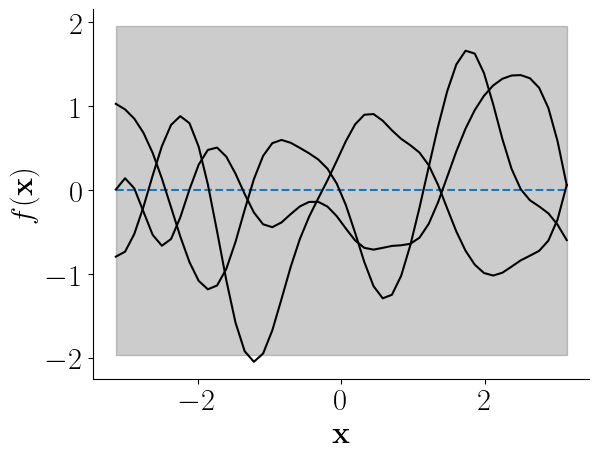

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(0.5)
GP = GaussianProcessRegressor(kernel=kernel,
                              random_state=0
                             )
mu_s, cov_s = GP.predict(x, return_cov=True)
uncertainty = 1.96 * np.sqrt(np.diag(cov_s))
samples = np.random.multivariate_normal(mu_s, cov_s, 3)

with plt.style.context(plt_style):
    fig, ax = plt.subplots()
    ax.plot(x, mu_s, label='Mean', ls='--')
    for s in samples:
        ax.plot(x, s, color='k')
    ax.fill_between(x.flatten(), 
                    mu_s+uncertainty, mu_s-uncertainty, 
                    color='k', 
                    alpha=0.2,
                    label=r'$3\sigma$'
                   )
    ax.set_xlabel(r'$\mathbf{x}$')
    ax.set_ylabel(r'$f(\mathbf{x})$')
    plt.savefig('./figures/lec17_1.pdf')
    plt.show()    

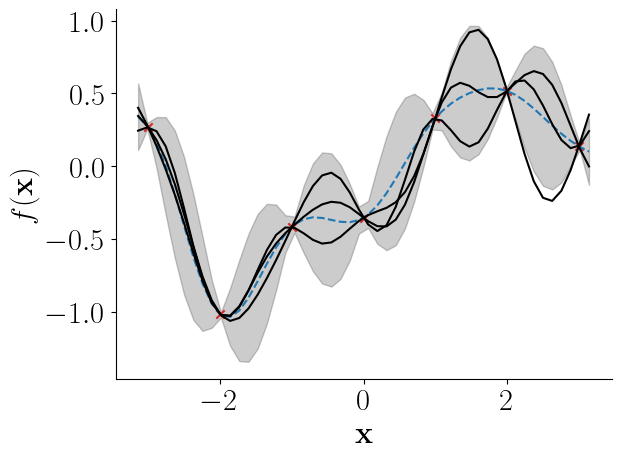

In [4]:
# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

GP.fit(X_train, Y_train)
mu_s, cov_s = GP.predict(x, return_cov=True)
uncertainty = 1.96 * np.sqrt(np.diag(cov_s))

samples = np.random.multivariate_normal(mu_s, cov_s, 3)

with plt.style.context(plt_style):
    fig, ax = plt.subplots()
    ax.plot(x, mu_s, label='Mean', ls='--')
    for s in samples:
        ax.plot(x, s, color='k')
    ax.fill_between(x.flatten(), 
                    mu_s+uncertainty, mu_s-uncertainty, 
                    color='k', 
                    alpha=0.2,
                    label=r'$3\sigma$'
                   )
    ax.scatter(X_train, Y_train, marker='x', color='tab:red')
    ax.set_xlabel(r'$\mathbf{x}$')
    ax.set_ylabel(r'$f(\mathbf{x})$')
    plt.savefig('./figures/lec17_2.pdf')
    plt.show()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [μ_]
>NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


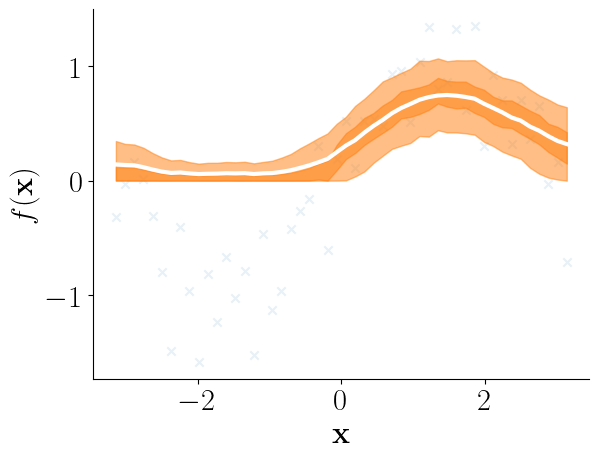

In [8]:
import pymc as pm
import xarray as xr
import pymc_bart as pmb
import arviz as az

RANDOM_SEED = 2023
rng = np.random.default_rng(RANDOM_SEED)

x_data = x[:, None]
y = y0.flatten()
with pm.Model() as model_coal:
    μ_ = pmb.BART("μ_", X=x_data, Y=y, m=50)
    μ = pm.Deterministic("μ", np.abs(μ_))
    
    sigma = pm.HalfCauchy("sigma", beta=10)
    y_pred = pm.Normal("y_pred", mu=μ, sigma=sigma, observed=y)
    idata = pm.sample(random_seed=RANDOM_SEED)
    
with plt.style.context(plt_style):    
    _, ax = plt.subplots()

    rates = idata.posterior["μ"]
    rate_mean = idata.posterior["μ"].mean(dim=["draw", "chain"])
    ax.scatter(x,y, marker='x', alpha=0.1)
    ax.plot(x, rate_mean, "w", lw=3)
    az.plot_hdi(x, rates, smooth=False)
    az.plot_hdi(x, rates, hdi_prob=0.5, smooth=False, plot_kwargs={"alpha": 0})
    ax.set_xlabel(r'$\mathbf{x}$')
    ax.set_ylabel(r'$f(\mathbf{x})$')
    plt.savefig('./figures/lec17_3.pdf')
    plt.show()